# LoL v12.2 - Jinx 1000 Generic Game Analysis

## Issues

### Currently dropped rows

- obj_type
- name
- spell_name (for each spell)

The obj_type, name and spell name all need to be one-hot encoded so a model can use this
information rather than just removing it.

### Dead minions not handled properly

Dead minions are included for auto attack inferences (because of timing issues,
the missile and the minion being dead can both be present).
However because dead minions are preserved in observations, this means that
dead minions are included as a possible auto attack target which is pointless
and also limits the number of alive minions the a model can look at (as dead
and alive minions contribute to the 30 allied / enemy minions per obs).

## Collate Observations

### Load All Observations

In [1]:
import sqlite3
import pandas as pd
import numpy as np

# game_id = "5678669359" # NOTE: This was the originally working one!!!
# game_id = "567922_2_1_39" # NOTE: This second one seems to work as well!
# game_id = "5690511853" # NOTE: Third seems alright?
game_id = "5700422593"
player  = "jinx"        # Target player (to designate as "me")

db_path = f"C:\\Users\\win8t\\OneDrive\\Desktop\\Patch 12.2 Jinx 1000 3k\\EUW1-{game_id}.db"
con     = sqlite3.connect(db_path)

### Collate Champion Observations

In [2]:
champs_sql = pd.read_sql_query("SELECT * FROM champs", con)
champs_df  = pd.DataFrame(champs_sql)
champs_df  = champs_df.drop(labels=["game_id"], axis=1)
champs_df  = champs_df[champs_df["time"] > 5.0]

champs_df

,time,obj_type,net_id,obj_id,name,health,max_health,team,armour,mr,...,max_mana,ability_haste,ap,lethality,experience,mana_regen,health_regen,attack_range,current_gold,total_gold
310,5.202038,champs,1073741856,2588,jhin,585.000000,585.000000,100,30.000000,30.000000,...,300.000000,0.0,0.0,0.0,0.000000,1.20000,0.75000,550.0,500.000000,500.000000
311,5.202038,champs,1073741860,2577,lissandra,620.000000,620.000000,200,28.000000,30.000000,...,475.000000,0.0,33.0,0.0,0.000000,1.60000,1.40000,550.0,0.000000,500.000000
312,5.202038,champs,1073741858,2580,renekton,670.000000,670.000000,200,41.000000,32.000000,...,100.000000,0.0,0.0,0.0,0.000000,0.00000,1.60000,125.0,0.000000,500.000000
313,5.202038,champs,1073741862,2570,lulu,525.000000,525.000000,200,35.000000,30.000000,...,350.000000,8.0,9.0,0.0,0.000000,2.20000,1.20000,550.0,500.000000,500.000000
314,5.202038,champs,1073741857,2586,lux,490.000000,490.000000,100,25.000000,30.000000,...,480.000000,0.0,18.0,0.0,0.000000,1.60000,1.10000,550.0,500.000000,500.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17591,299.743866,champs,1073741862,2570,lulu,644.150024,644.150024,200,40.457500,30.737499,...,506.125000,8.0,17.0,0.0,958.482117,3.56550,1.37700,550.0,190.600677,1065.598145
17592,299.743866,champs,1073741854,2593,ivern,558.195190,777.525024,100,40.927502,34.831249,...,585.900024,8.0,9.0,0.0,1359.018188,1.53975,1.78505,475.0,934.604553,1434.607056
17593,299.743866,champs,1073741861,2572,jinx,736.849976,736.849976,200,37.162498,30.737499,...,411.375000,0.0,0.0,0.0,1018.932129,1.63500,0.89750,525.0,43.602062,1318.607300
17594,299.743866,champs,1073741853,2612,irelia,276.066498,939.900024,100,51.270000,31.862499,...,504.500000,0.0,0.0,0.0,2049.217773,2.09440,2.22530,200.0,652.004517,2202.010010


In [3]:
len(set(champs_df["time"]))

1499

In [4]:
champs_df["name"].value_counts()

lulu         1977
jhin         1776
lissandra    1744
renekton     1739
lux          1675
leesin       1675
jinx         1675
ivern        1675
irelia       1675
corki        1675
Name: name, dtype: int64

#### Remove Duplicate Observations

In [5]:
champs_df = champs_df.drop_duplicates(subset=["time", "obj_type", "name"])
champs_df

,time,obj_type,net_id,obj_id,name,health,max_health,team,armour,mr,...,max_mana,ability_haste,ap,lethality,experience,mana_regen,health_regen,attack_range,current_gold,total_gold
310,5.202038,champs,1073741856,2588,jhin,585.000000,585.000000,100,30.000000,30.000000,...,300.000000,0.0,0.0,0.0,0.000000,1.20000,0.75000,550.0,500.000000,500.000000
311,5.202038,champs,1073741860,2577,lissandra,620.000000,620.000000,200,28.000000,30.000000,...,475.000000,0.0,33.0,0.0,0.000000,1.60000,1.40000,550.0,0.000000,500.000000
312,5.202038,champs,1073741858,2580,renekton,670.000000,670.000000,200,41.000000,32.000000,...,100.000000,0.0,0.0,0.0,0.000000,0.00000,1.60000,125.0,0.000000,500.000000
313,5.202038,champs,1073741862,2570,lulu,525.000000,525.000000,200,35.000000,30.000000,...,350.000000,8.0,9.0,0.0,0.000000,2.20000,1.20000,550.0,500.000000,500.000000
314,5.202038,champs,1073741857,2586,lux,490.000000,490.000000,100,25.000000,30.000000,...,480.000000,0.0,18.0,0.0,0.000000,1.60000,1.10000,550.0,500.000000,500.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17591,299.743866,champs,1073741862,2570,lulu,644.150024,644.150024,200,40.457500,30.737499,...,506.125000,8.0,17.0,0.0,958.482117,3.56550,1.37700,550.0,190.600677,1065.598145
17592,299.743866,champs,1073741854,2593,ivern,558.195190,777.525024,100,40.927502,34.831249,...,585.900024,8.0,9.0,0.0,1359.018188,1.53975,1.78505,475.0,934.604553,1434.607056
17593,299.743866,champs,1073741861,2572,jinx,736.849976,736.849976,200,37.162498,30.737499,...,411.375000,0.0,0.0,0.0,1018.932129,1.63500,0.89750,525.0,43.602062,1318.607300
17594,299.743866,champs,1073741853,2612,irelia,276.066498,939.900024,100,51.270000,31.862499,...,504.500000,0.0,0.0,0.0,2049.217773,2.09440,2.22530,200.0,652.004517,2202.010010


In [6]:
champs_df["name"].value_counts()

jhin         1499
lissandra    1499
renekton     1499
lulu         1499
lux          1499
leesin       1499
jinx         1499
ivern        1499
irelia       1499
corki        1499
Name: name, dtype: int64

#### Ensure Summoner Spell Consistency

In [14]:
# NOTE: This is disabled for now as it's not required to train the model
"""
if champs_df.iloc[0]["f_name"] == "summonerflash":
    champs_df = champs_df.rename(\
        columns={
            "d_name": "f_name",
            "d_level": "f_level",
            "d_cd": "f_cd",
            "f_name": "d_name",
            "f_level": "d_level",
            "f_cd": "d_cd"})
"""

'\nif champs_df.iloc[0]["f_name"] == "summonerflash":\n    champs_df = champs_df.rename(        columns={\n            "d_name": "f_name",\n            "d_level": "f_level",\n            "d_cd": "f_cd",\n            "f_name": "d_name",\n            "f_level": "d_level",\n            "f_cd": "d_cd"})\n'

#### Add Previous Positions

In [15]:
# Fill previous positions by copying current positions and shifting them ahead
champs_prev_pos_x = champs_df["position_x"].shift(10)
champs_prev_pos_y = champs_df["position_y"].shift(10)
champs_prev_pos_z = champs_df["position_z"].shift(10)
champs_df["prev_position_x"] = champs_prev_pos_x
champs_df["prev_position_y"] = champs_prev_pos_y
champs_df["prev_position_z"] = champs_prev_pos_z

# Fill first previous positions with zeroes
champs_df = champs_df.fillna(0)

C:\Users\win8t\AppData\Local\Temp/ipykernel_19572/104326869.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  champs_df["prev_position_x"] = champs_prev_pos_x
C:\Users\win8t\AppData\Local\Temp/ipykernel_19572/104326869.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  champs_df["prev_position_y"] = champs_prev_pos_y
C:\Users\win8t\AppData\Local\Temp/ipykernel_19572/104326869.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

#### Calculate Position Deltas

In [16]:
import math

champs_df["position_x_delta"]   = champs_df["position_x"] - champs_df["prev_position_x"]
champs_df["position_z_delta"]   = champs_df["position_z"] - champs_df["prev_position_z"]
champs_df["position_x_z_delta"] = [math.dist((x, y), (prev_x, prev_y))
                                   for x, y, prev_x, prev_y in \
                                   zip(champs_df["position_x"],
                                       champs_df["position_z"],
                                       champs_df["prev_position_x"],
                                       champs_df["prev_position_z"])]

def digitize_delta(val):
    if   val < -350:                 return -4
    elif val > -350 and val <= -250: return -3
    elif val > -250 and val <= -150: return -2
    elif val > -150 and val <= -50:  return -1
    elif val > -50  and val <=  50:  return +0
    elif val >= 50  and val <   150: return +1
    elif val >= 150 and val <   250: return +2
    elif val >= 250 and val <   350: return +3
    else:                            return +4

pos_x_delta_digital = \
    champs_df["position_x_delta"].apply(lambda val: digitize_delta(val))
pos_z_delta_digital = \
    champs_df["position_z_delta"].apply(lambda val: digitize_delta(val))

champs_df["position_x_delta_digital"] = pos_x_delta_digital
champs_df["position_z_delta_digital"] = pos_z_delta_digital

#### Get Spell Casts

In [17]:
champs_q_cd_prev = champs_df["q_cd"].shift(10)
champs_w_cd_prev = champs_df["w_cd"].shift(10)
champs_e_cd_prev = champs_df["e_cd"].shift(10)
champs_r_cd_prev = champs_df["r_cd"].shift(10)
champs_d_cd_prev = champs_df["d_cd"].shift(10)
champs_f_cd_prev = champs_df["f_cd"].shift(10)

champs_df["q_prev_cd"] = champs_q_cd_prev
champs_df["w_prev_cd"] = champs_w_cd_prev
champs_df["e_prev_cd"] = champs_e_cd_prev
champs_df["r_prev_cd"] = champs_r_cd_prev
champs_df["d_prev_cd"] = champs_d_cd_prev
champs_df["f_prev_cd"] = champs_f_cd_prev

def is_spell_cast(row, spell):
    return (row[f"{spell}_prev_cd"] < row[f"{spell}_cd"]) & (row[f"{spell}_prev_cd"] == 0)

for spell in ["q", "w", "e", "r", "d", "f"]:
    champs_df[f"{spell}_cast"] = \
        champs_df.apply(lambda row: is_spell_cast(row, spell), axis=1)

champs_df = champs_df.fillna(0)

#### Get X, Y, (X, Y) Distances from Player

In [18]:
import math

# Get player data only, useful for next step
player_df = champs_df[champs_df["name"] == player]
player_pos = {}
def set_player_pos(player_pos, row):
    player_pos[row["time"]] = [row["position_x"], row["position_z"]]
player_df.apply(lambda row: set_player_pos(player_pos, row), axis=1)
player_pos

def linear_diff(row, col, player_pos_idx):
    return row[col] - player_pos[row["time"]][player_pos_idx]

def multi_diff(row):
    cur_pos  = row[["position_x", "position_z"]]
    player_p = player_pos[row["time"]]
    return math.dist(cur_pos, player_p)

x_champ_diffs   = champs_df[["time", "position_x"]].apply(\
    lambda row: linear_diff(row,
                            "position_x",
                            player_pos_idx=0), axis=1)
z_champ_diffs   = champs_df[["time", "position_z"]].apply(\
    lambda row: linear_diff(row,
                            "position_z",
                            player_pos_idx=1), axis=1)

x_z_champ_diffs = champs_df[["time", "position_x", "position_z"]].apply(\
    lambda row: multi_diff(row), axis=1)

#### Append X, Y, (X, Y) Distances from Player

In [19]:
champs_df["x_diff_from_player"]   = x_champ_diffs
champs_df["z_diff_from_player"]   = z_champ_diffs
champs_df["x_z_diff_from_player"] = x_z_champ_diffs

### Collate Object Observations

In [20]:
objects_sql = pd.read_sql_query("SELECT * FROM objects", con)
objects_df  = pd.DataFrame(objects_sql)
objects_df  = objects_df.drop(labels=["game_id"], axis=1)
objects_df  = objects_df[objects_df["time"] > 5.0]

objects_df

,time,obj_type,net_id,obj_id,name,health,max_health,team,armour,mr,movement_speed,is_alive,position_x,position_y,position_z,is_moving,targetable,invulnerable,recallState
809,5.202038,turrets,1073741828,2564,sruap_turret_order1,5.000000e+03,5000.0,100,1.500000e+01,15.00000,0.0,1,10504.000000,41.000000,1029.000000,1,0,1,0
810,5.202038,turrets,1073741829,2560,sruap_turret_order2,3.600000e+03,3600.0,100,5.500000e+01,55.00000,0.0,1,6919.000000,43.000000,1483.000000,1,0,1,0
811,5.202038,turrets,1073741831,2550,sruap_turret_chaos1,5.000000e+03,5000.0,200,1.500000e+01,15.00000,0.0,1,13866.000000,38.000000,4505.000000,1,0,1,0
812,5.202038,turrets,1073741830,2556,sruap_turret_order3,3.300000e+03,3300.0,100,7.000000e+01,70.00000,0.0,1,4281.000000,86.000000,1253.000000,1,0,1,0
813,5.202038,turrets,1073741835,2615,sruap_turret_order2,3.600000e+03,3600.0,100,5.500000e+01,55.00000,0.0,1,5048.000000,43.000000,4812.000000,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148397,299.743866,others,1073747211,2627,sru_plant_satchel,1.000000e+00,1.0,300,0.000000e+00,0.00000,0.0,1,8848.000000,53.773663,3669.000000,0,0,1,0
148398,299.743866,others,1073748373,2634,sru_plant_health,1.000000e+00,1.0,300,0.000000e+00,0.00000,0.0,1,4478.000000,-66.651978,9034.000000,0,0,1,0
148399,299.743866,others,1073748385,176,[x,3.343785e+15,0.0,0,0.000000e+00,0.00000,0.0,1,4064.000000,52.838100,13736.000000,0,0,1,0
148400,299.743866,others,1073748432,2785,__mul,1.317448e+12,0.0,0,1.010192e-39,6952.15625,0.0,1,12786.000000,51.366901,3222.000000,1,1,1,0


In [21]:
objects_df["name"].value_counts()

sru_chaosminionranged           17703
sru_orderminionranged           17487
sru_orderminionmelee            15031
sru_chaosminionmelee            14663
sru_razorbeakmini                8152
                                ...  
play_sfx_blindmonkeone_onhit        4
perks_arcanecomet_mis_arc           3
dgetpartitionproperty               3
firststrike_mis2                    2
promocontroller                     2
Name: name, Length: 70, dtype: int64

#### Remove Duplicate Observations

In [22]:
objects_df = objects_df.drop_duplicates(subset=["time", "obj_type", "name", "net_id"])
# objects_df = objects_df.drop_duplicates(subset=["time", "obj_type", "name"])
objects_df[(objects_df["time"] > 89) & (objects_df["time"] < 90) & (objects_df["obj_type"] == "jungle")]

,time,obj_type,net_id,obj_id,name,health,max_health,team,armour,mr,movement_speed,is_alive,position_x,position_y,position_z,is_moving,targetable,invulnerable,recallState
28227,89.048203,jungle,1073742198,2602,sru_red,1850.0,1850.0,300,20.0,20.0,275.0,1,7765.244141,53.956444,4020.187012,0,0,1,0
28228,89.048203,jungle,1073742203,2444,sru_blue,1850.0,1850.0,300,20.0,20.0,275.0,1,3821.488525,52.035931,7901.054199,0,0,1,0
28229,89.048203,jungle,1073742211,176,sru_razorbeakmini,425.0,425.0,300,0.0,0.0,492.5,1,7060.458008,54.988708,5499.273926,1,0,1,0
28230,89.048203,jungle,1073742200,2548,sru_red,1850.0,1850.0,300,20.0,20.0,275.0,1,7101.869141,56.282677,10900.546875,1,0,1,0
28231,89.048203,jungle,1073742205,182,sru_blue,1850.0,1850.0,300,20.0,20.0,275.0,1,11031.728516,51.723640,6990.844238,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28665,89.804306,jungle,1073742228,135,sru_murkwolf,1200.0,1200.0,300,20.0,20.0,492.5,1,11008.152344,62.090504,8387.408203,1,0,1,0
28666,89.804306,jungle,1073742232,127,sru_murkwolfmini,480.0,480.0,300,0.0,0.0,492.5,1,10808.152344,63.012882,8387.408203,1,0,1,0
28667,89.804306,jungle,1073742236,2470,sru_razorbeakmini,425.0,425.0,300,0.0,0.0,492.5,1,7886.996582,52.445015,9312.389648,1,0,1,0
28668,89.804306,jungle,1073742240,2458,sru_razorbeakmini,425.0,425.0,300,0.0,0.0,492.5,1,7854.389160,52.265751,9610.473633,1,0,1,0


In [23]:
objects_df["name"].value_counts()

sru_orderminionranged        14474
sru_chaosminionranged        14156
sru_orderminionmelee         12426
sru_chaosminionmelee         12254
sru_razorbeakmini             6676
                             ...  
@cw                           3
perks_arcanecomet_mis_arc        3
dgetpartitionproperty            3
firststrike_mis2                 2
promocontroller                  2
Name: name, Length: 70, dtype: int64

#### Get X, Y, (X, Y) Distances from Player

In [24]:
import math

# Get player data only, useful for next step
player_df = champs_df[champs_df["name"] == player]
player_pos = {}
def set_player_pos(player_pos, row):
    player_pos[row["time"]] = [row["position_x"], row["position_z"]]
player_df.apply(lambda row: set_player_pos(player_pos, row), axis=1)
player_pos

def linear_diff(row, col, player_pos_idx):
    return row[col] - player_pos[row["time"]][player_pos_idx]

def multi_diff(row):
    cur_pos  = row[["position_x", "position_z"]]
    player_p = player_pos[row["time"]]
    return math.dist(cur_pos, player_p)

x_obj_diffs   = objects_df[["time", "position_x"]].apply(\
    lambda row: linear_diff(row,
                            "position_x",
                            player_pos_idx=0), axis=1)
z_obj_diffs   = objects_df[["time", "position_z"]].apply(\
    lambda row: linear_diff(row,
                            "position_z",
                            player_pos_idx=1), axis=1)

x_z_obj_diffs = objects_df[["time", "position_x", "position_z"]].apply(\
    lambda row: multi_diff(row), axis=1)

#### Append X, Y, (X, Y) Distances from Player

In [25]:
objects_df["x_diff_from_player"]   = x_obj_diffs
objects_df["z_diff_from_player"]   = z_obj_diffs
objects_df["x_z_diff_from_player"] = x_z_obj_diffs

C:\Users\win8t\AppData\Local\Temp/ipykernel_19572/1683498737.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  objects_df["x_diff_from_player"]   = x_obj_diffs
C:\Users\win8t\AppData\Local\Temp/ipykernel_19572/1683498737.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  objects_df["z_diff_from_player"]   = z_obj_diffs
C:\Users\win8t\AppData\Local\Temp/ipykernel_19572/1683498737.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

In [26]:
objects_df.shape

(124562, 22)

### Collate Missile Observations

In [27]:
missiles_sql = pd.read_sql_query("SELECT * FROM missiles", con)
missiles_df  = pd.DataFrame(missiles_sql)
missiles_df  = missiles_df.drop(labels=["game_id"], axis=1)
missiles_df  = missiles_df[missiles_df["time"] > 5.0]

In [28]:
missiles_df["name"].value_counts()

sru_orderminionrangedbasicattack2    2017
sru_orderminionrangedbasicattack     1803
sru_chaosminionrangedbasicattack     1757
sru_chaosminionrangedbasicattack2    1535
sru_chaosminionsiegebasicattack       220
sru_orderminionsiegebasicattack       219
lulupassivemissile                    131
sruap_turret_order1basicattack         78
lulupassivemissilecontroller           66
sruap_turret_chaos1basicattack         63
jhinqmisbounce                         53
ireliaeparticlemissile                 49
luxlightstrikekugel                    42
corkibasicattack2                      39
phosphorusbombmissile                  39
corkibasicattack                       37
lissandrabasicattack2                  37
jinxqattack2                           32
lissandrabasicattack                   32
ireliaemissile                         32
lissandraqshards                       31
blindmonkqone                          27
lissandraqmissile                      25
ivernq                            

#### Remove Duplicate Observations

In [29]:
missiles_df = missiles_df.drop_duplicates(subset=["time", "obj_type", "name", "net_id"])
missiles_df

,time,obj_type,net_id,obj_id,name,health,max_health,team,armour,mr,...,position_y,position_z,start_position_x,start_position_y,start_position_z,end_position_x,end_position_y,end_position_z,source_idx,destination_idx
0,88.257690,missiles,1073742196,456,lissandrabasicattack2,1.299360e+04,0.000000e+00,200,0.000000e+00,-1.000000e+00,...,195.141235,7459.307129,7814.412598,53.982845,7645.725586,7274.817383,54.330799,7289.120117,2577,1
1,88.257690,missiles,1073742197,2516,corkibasicattack,-5.621348e-03,-2.353774e-03,100,0.000000e+00,0.000000e+00,...,169.125336,7333.949219,7250.951660,53.522903,6975.583984,7545.164062,53.325199,7519.037598,2591,1
2,88.533035,missiles,1073742197,2516,corkibasicattack,-5.621348e-03,-2.353774e-03,100,0.000000e+00,0.000000e+00,...,169.125336,7333.949219,7250.951660,53.522903,6975.583984,7545.164062,53.325199,7519.037598,2591,1
3,89.615128,missiles,1073742249,151,lissandraqmissile,0.000000e+00,0.000000e+00,200,0.000000e+00,6.924000e+03,...,221.929047,7306.376465,7573.914062,153.430725,7659.506836,7176.970703,153.430725,7023.161133,2577,0
4,89.804306,missiles,1073742221,1733,sru_orderminionrangedbasicattack2,0.000000e+00,0.000000e+00,100,0.000000e+00,0.000000e+00,...,92.611404,7122.629395,7005.587891,52.219536,7050.023926,7450.756836,53.934593,7291.537109,2403,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8731,299.743866,missiles,1073747957,2777,sru_orderminionrangedbasicattack2,-3.948420e-31,1.805695e+28,100,0.000000e+00,0.000000e+00,...,85.072594,13643.078125,3749.862305,52.838104,13525.940430,4318.000000,38.000000,13875.000000,381,1
8732,299.743866,missiles,1073747978,2636,sru_orderminionrangedbasicattack,0.000000e+00,0.000000e+00,100,7.873536e-03,0.000000e+00,...,114.013275,3225.996826,13181.827148,51.366901,2906.993408,13124.183594,51.366901,3515.157471,170,1
8733,299.743866,missiles,1073747031,1751,sru_orderminionrangedbasicattack2,1.883884e-38,2.100000e+00,100,-1.145750e-13,0.000000e+00,...,85.308136,13752.933594,3631.186768,52.838097,13660.985352,4318.000000,38.000000,13875.000000,2775,1
8734,299.743866,missiles,1073748437,871,sru_orderminionrangedbasicattack,0.000000e+00,4.144285e-38,100,1.390740e+19,7.770502e+34,...,101.253265,6747.419434,6404.257324,51.767563,6641.574707,6953.498047,52.089539,6972.383301,2780,1


In [30]:
missiles_df["name"].value_counts()

sru_orderminionrangedbasicattack2    1695
sru_orderminionrangedbasicattack     1537
sru_chaosminionrangedbasicattack     1458
sru_chaosminionrangedbasicattack2    1269
sru_chaosminionsiegebasicattack       196
sru_orderminionsiegebasicattack       195
lulupassivemissile                    113
sruap_turret_order1basicattack         68
lulupassivemissilecontroller           59
sruap_turret_chaos1basicattack         53
jhinqmisbounce                         46
ireliaeparticlemissile                 42
luxlightstrikekugel                    37
corkibasicattack2                      36
corkibasicattack                       34
lissandrabasicattack2                  34
phosphorusbombmissile                  33
lissandrabasicattack                   29
lissandraqshards                       28
jinxqattack2                           25
ireliaemissile                         25
blindmonkqone                          24
lissandraqmissile                      22
ivernq                            

#### Get X, Y, (X, Y) Distances from Player

In [31]:
import math

# Get player data only, useful for next step
player_df = champs_df[champs_df["name"] == player]
player_pos = {}
def set_player_pos(player_pos, row):
    player_pos[row["time"]] = [row["position_x"], row["position_z"]]
player_df.apply(lambda row: set_player_pos(player_pos, row), axis=1)
player_pos

def linear_diff(row, col, player_pos_idx):
    return row[col] - player_pos[row["time"]][player_pos_idx]

def multi_diff(row):
    cur_pos  = row[["position_x", "position_z"]]
    player_p = player_pos[row["time"]]
    return math.dist(cur_pos, player_p)

x_missile_diffs   = missiles_df[["time", "position_x"]].apply(\
    lambda row: linear_diff(row,
                            "position_x",
                            player_pos_idx=0), axis=1)
z_missile_diffs   = missiles_df[["time", "position_z"]].apply(\
    lambda row: linear_diff(row,
                            "position_z",
                            player_pos_idx=1), axis=1)

x_z_missile_diffs = missiles_df[["time", "position_x", "position_z"]].apply(\
    lambda row: multi_diff(row), axis=1)

#### Append X, Y, (X, Y) Distances from Player

In [32]:
missiles_df["x_diff_from_player"]   = x_missile_diffs
missiles_df["z_diff_from_player"]   = z_missile_diffs
missiles_df["x_z_diff_from_player"] = x_z_missile_diffs

In [33]:
missiles_df.shape

(7380, 26)

## Infer Actions

### Infer Auto Attacks (for Player)

#### Get Auto Attack Missiles

In [34]:
aa_missile_names = [
    "jinxbasicattack",
    "jinxbasicattack2",
    "jinxqattack",
    "jinxqattack2"]

aa_missiles = missiles_df[missiles_df["name"].isin(aa_missile_names)]
aa_missiles

,time,obj_type,net_id,obj_id,name,health,max_health,team,armour,mr,...,start_position_y,start_position_z,end_position_x,end_position_y,end_position_z,source_idx,destination_idx,x_diff_from_player,z_diff_from_player,x_z_diff_from_player
19,90.580360,missiles,1073742275,2228,jinxbasicattack,0.000000e+00,0.0,200,-2.436741e+24,0.000000,...,51.718224,6761.667969,11031.728516,51.723640,6990.844238,2572,1,-427.852539,232.979004,487.172466
25,90.740250,missiles,1073742275,2228,jinxbasicattack,0.000000e+00,0.0,200,0.000000e+00,1.000000,...,51.718224,6761.667969,11031.728516,51.723640,6990.844238,2572,1,-427.852539,232.979004,487.172466
62,91.995224,missiles,1073742326,1640,jinxbasicattack2,1.103173e+04,0.0,200,0.000000e+00,0.958838,...,51.717480,6726.675781,11031.728516,51.723640,6990.844238,2572,1,-375.312500,208.012695,429.102265
66,92.140221,missiles,1073742326,1640,jinxbasicattack2,1.103173e+04,0.0,200,0.000000e+00,0.958838,...,51.717480,6726.675781,11031.728516,51.723640,6990.844238,2572,1,-375.312500,208.012695,429.102265
98,93.283470,missiles,1073742366,2422,jinxbasicattack,1.112328e+04,0.0,200,0.000000e+00,0.000000,...,51.717480,6726.675781,11031.728516,51.723640,6990.844238,2572,1,-387.390625,214.741211,442.928080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6469,250.577087,missiles,1073747025,1640,jinxbasicattack,4.171753e+02,1.0,200,-3.189542e+01,30.266975,...,51.366905,2883.559570,12966.404297,51.366901,2988.090576,2572,1,-60.333984,-28.503906,66.728272
6540,252.244934,missiles,1073747045,1487,jinxbasicattack2,1.401298e-45,0.0,200,1.401298e-45,13716.000000,...,51.366901,3234.763672,13055.560547,51.366901,2976.817139,2572,1,-112.006836,10.589111,112.506269
6787,257.161591,missiles,1073747088,530,jinxbasicattack,0.000000e+00,0.0,200,2.544077e-29,1.000000,...,51.366901,3384.262207,13238.110352,51.366905,3166.494629,2572,1,-38.253906,-73.104492,82.508352
7033,262.915649,missiles,1073747207,1168,jinxbasicattack2,1.181720e+04,0.0,200,1.401298e-45,13018.000000,...,51.366901,3067.896240,12919.007812,51.366901,3084.311035,2572,1,-110.135742,13.629395,110.975863


#### Get Auto Attack Destination Objects

In [35]:
aa_missile_dst_s = aa_missiles[["time", "end_position_x", "end_position_z", "x_diff_from_player", "z_diff_from_player", "x_z_diff_from_player"]]

def find_aa_target(row):
    # Get auto attack time and destination
    t, x, z = row[["time", "end_position_x", "end_position_z"]]
    
    # Search turrets, jungle camps and minions for auto attack destination
    found_obj = objects_df[\
        (objects_df["position_x"] == x) &
        (objects_df["position_z"] == z)]
    if len(found_obj) > 0:
        return found_obj.iloc[0]["obj_type"], found_obj.iloc[0]["net_id"]

    # Search champs for auto attack destination
    found_champ = champs_df[\
        (champs_df["position_x"] == x) &
        (champs_df["position_z"] == z)]
    if len(found_champ) > 0:
        return found_champ.iloc[0]["obj_type"], found_champ.iloc[0]["net_id"]
        
    return None, -1

aa_missile_dst      = aa_missile_dst_s.apply(lambda row: find_aa_target(row), axis=1)
aa_missile_dst_type = aa_missile_dst.apply(lambda data: data[0])
aa_missile_dst_id   = aa_missile_dst.apply(lambda data: data[1])

In [36]:
aa_missile_dst_s["target_type"] = aa_missile_dst_type
aa_missile_dst_s["target_id"]   = aa_missile_dst_id
aa_missile_dst_s

C:\Users\win8t\AppData\Local\Temp/ipykernel_19572/2551157655.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aa_missile_dst_s["target_type"] = aa_missile_dst_type
C:\Users\win8t\AppData\Local\Temp/ipykernel_19572/2551157655.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aa_missile_dst_s["target_id"]   = aa_missile_dst_id


,time,end_position_x,end_position_z,x_diff_from_player,z_diff_from_player,x_z_diff_from_player,target_type,target_id
19,90.580360,11031.728516,6990.844238,-427.852539,232.979004,487.172466,jungle,1073742205
25,90.740250,11031.728516,6990.844238,-427.852539,232.979004,487.172466,jungle,1073742205
62,91.995224,11031.728516,6990.844238,-375.312500,208.012695,429.102265,jungle,1073742205
66,92.140221,11031.728516,6990.844238,-375.312500,208.012695,429.102265,jungle,1073742205
98,93.283470,11031.728516,6990.844238,-387.390625,214.741211,442.928080,jungle,1073742205
...,...,...,...,...,...,...,...,...
6469,250.577087,12966.404297,2988.090576,-60.333984,-28.503906,66.728272,minions,1073745233
6540,252.244934,13055.560547,2976.817139,-112.006836,10.589111,112.506269,minions,1073745268
6787,257.161591,13238.110352,3166.494629,-38.253906,-73.104492,82.508352,minions,1073746200
7033,262.915649,12919.007812,3084.311035,-110.135742,13.629395,110.975863,minions,1073745198


### Infer Spell Casts (for Player)

#### Infer Basic Spell Casts

##### Get Basic Spell Missiles (Where Applicable)

In [37]:
# Find obs where player w's
w_missiles    = missiles_df[missiles_df["name"] == "jinxwmissile"].index
w_missile_tms = missiles_df[missiles_df.index.isin(w_missiles)]["time"]
w_s           = player_df[player_df["w_cast"] == True]

In [38]:
from itertools import compress

# Find obs where player e's
e_missiles    = missiles_df[missiles_df["name"] == "jinxehit"].index
e_missile_tms = missiles_df[missiles_df.index.isin(e_missiles)]["time"]
e_s           = []

# Filter multiple e missiles corresponding to same missile
# ... (i.e. if there's 3 missiles for one e_cast, keep only the first missile)
e_missile_filter = [True]
for i in range(len(e_missiles[:-1])):
    cur_tm  = e_missile_tms.iloc[i]
    next_tm = e_missile_tms.iloc[i + 1]
    if next_tm - cur_tm < 5.0: # Jinx E is never 5 sec or lower so this is guaranteed to always be right
        e_missile_filter.append(False)
    else:
        e_missile_filter.append(True)
e_missiles    = list(compress(list(e_missiles),    e_missile_filter))
e_missile_tms = list(compress(list(e_missile_tms), e_missile_filter))

# Loop through all unique E spell casts
for e_missile_tm in e_missile_tms:
    current_window = player_df[\
        (abs(player_df["time"] - e_missile_tm) < 2) &
        (player_df["e_cast"] == True)]
    e_s.append(current_window)

#### Infer Summoner Spell Casts

In [39]:
# Find obs where player flashes, find the game times and then check within 2 sec (before and after) where they flash
flash_letter = "d" if player_df.iloc[0]["d_name"] == "flash" else "f"
f_cast_idxs  = player_df[player_df[f"{flash_letter}_cast"] == True].index
f_cast_tms   = player_df[player_df.index.isin(f_cast_idxs)]["time"]
flashes      = []
print(f_cast_tms)
for cast_tm in f_cast_tms:
    current_window = player_df[\
        (abs(player_df["time"] - cast_tm) < 2) &
        (player_df["position_x_z_delta"] > 300.0)]
    print("CUR!", current_window[["time", "position_x_z_delta"]])
    flashes.append(current_window.iloc[0])
flashes

Series([], Name: time, dtype: float64)


[]

### Infer Ward Placements (for Player)

In [40]:
# Infer ward placements from ward distances to player
player_frame = player_df[player_df["name"] == player]
player_team  = player_frame.iloc[0]["team"]
ward_names = ["jammerdevice",
              "yellowtrinket",
              "ward"]

allied_wards = objects_df[\
    (objects_df["team"] == player_team) &
    (objects_df["name"].isin(ward_names)) &
    (objects_df["x_z_diff_from_player"] <= 600)].index
allied_ward_tms = objects_df[objects_df.index.isin(allied_wards)]["time"]

wards = []

# Filter ward objects corresponding to the same ward
# ... (i.e. if there's 3 missiles for one ward, keep only the first ward)
try:
    wards = [objects_df[objects_df.index == allied_wards[0]].iloc[0]]
    for i in range(len(allied_wards[:-1])):
        cur_tm  = allied_ward_tms.iloc[i]
        next_tm = allied_ward_tms.iloc[i + 1]
        if next_tm - cur_tm < 60.0: # Ward duration never lower than 90secs, so this should be fine
            pass
        else:
            wards.append(objects_df[objects_df.index == allied_wards.index])
except Exception as e:
    print(e)

wards

index 0 is out of bounds for axis 0 with size 0


[]

## Combine Obs/Acts

### Combine Champion Obs

#### Combine Allied Champion Obs

In [58]:
champs_df[champs_df["team"] == player_df.iloc[0]["team"]]

,time,obj_type,net_id,obj_id,name,health,max_health,team,armour,mr,...,f_prev_cd,q_cast,w_cast,e_cast,r_cast,d_cast,f_cast,x_diff_from_player,z_diff_from_player,x_z_diff_from_player
311,5.202038,champs,1073741860,2577,lissandra,620.000000,620.000000,200,28.000000,30.000000,...,0.000000,False,False,False,False,False,False,-356.000000,102.000000,370.324182
312,5.202038,champs,1073741858,2580,renekton,670.000000,670.000000,200,41.000000,32.000000,...,0.000000,False,False,False,False,False,False,-486.000000,-260.000000,551.176923
313,5.202038,champs,1073741862,2570,lulu,525.000000,525.000000,200,35.000000,30.000000,...,0.000000,False,False,False,False,False,False,-534.000000,38.000000,535.350353
315,5.202038,champs,1073741859,2579,leesin,575.000000,575.000000,200,36.000000,40.000000,...,0.000000,False,False,False,False,False,False,-162.000000,-284.000000,326.955654
316,5.202038,champs,1073741861,2572,jinx,610.000000,610.000000,200,32.000000,30.000000,...,0.000000,False,False,False,False,False,False,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17587,299.743866,champs,1073741860,2577,lissandra,255.711548,898.099976,200,39.432999,31.545000,...,51.840576,False,False,False,False,False,False,-6946.476562,281.556152,6952.180270
17588,299.743866,champs,1073741858,2580,renekton,0.000000,890.380005,200,50.060001,34.831249,...,272.854675,False,False,True,False,False,False,-9645.981445,6174.927246,11453.151729
17590,299.743866,champs,1073741859,2579,leesin,700.375000,700.375000,200,41.457500,41.843750,...,156.281097,False,False,False,False,False,False,-6879.635254,628.663086,6908.299248
17591,299.743866,champs,1073741862,2570,lulu,644.150024,644.150024,200,40.457500,30.737499,...,107.118896,False,False,False,False,False,False,-5557.273926,-970.074707,5641.306447


In [59]:
# Base allied_champs_df is player_df
allied_champs_df      = champs_df[champs_df["team"] == player_df.iloc[0]["team"]]
allied_champs_df      = allied_champs_df[allied_champs_df["name"] != player]
allied_champs_df      = allied_champs_df.sort_values(["time", "x_z_diff_from_player"], ascending=True)
allied_champs_df_base = champs_df[champs_df["name"] == player]

drop_columns = ["obj_type", "obj_id", "net_id", "name", "q_name", "w_name", "e_name", "r_name", "d_name", "f_name"]
allied_champs_df_base = allied_champs_df_base.drop(labels=drop_columns, axis=1)
allied_champs_df = allied_champs_df.drop(labels=drop_columns, axis=1)

allied_champ_count = 4
for i in range(allied_champ_count):
    cur_allied_champs_df  = allied_champs_df.iloc[i::allied_champ_count, :]
    allied_champs_df_base = \
        allied_champs_df_base.merge(
            cur_allied_champs_df,
            on="time",
            suffixes=('_0' if i == 0 else '', f'_{i+1}'))
            
allied_champs_df_base

,time,health_0,max_health_0,team_0,armour_0,mr_0,movement_speed_0,is_alive_0,position_x_0,position_y_0,...,f_prev_cd_4,q_cast_4,w_cast_4,e_cast_4,r_cast_4,d_cast_4,f_cast_4,x_diff_from_player_4,z_diff_from_player_4,x_z_diff_from_player_4
0,5.202038,610.000000,610.000000,200,32.000000,30.000000,676.875,1,14588.000000,171.977707,...,0.000000,False,False,False,False,False,False,-486.000000,-260.000000,551.176923
1,6.243157,610.000000,610.000000,200,32.000000,30.000000,676.875,1,14588.000000,171.977707,...,10.797962,False,False,False,False,False,False,-486.000000,-260.000000,551.176923
2,6.527338,610.000000,610.000000,200,32.000000,30.000000,676.875,1,14588.000000,171.977707,...,9.756844,False,False,False,False,False,False,-486.000000,-260.000000,551.176923
3,6.594130,610.000000,610.000000,200,32.000000,30.000000,676.875,1,14588.000000,171.977707,...,9.472662,False,False,False,False,False,False,-486.000000,-260.000000,551.176923
4,6.727624,610.000000,610.000000,200,32.000000,30.000000,676.875,1,14588.000000,171.977707,...,9.405870,False,False,False,False,False,False,-486.000000,-260.000000,551.176923
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1494,298.560089,736.849976,736.849976,200,37.162498,30.737499,350.000,1,13731.624023,52.306301,...,274.094055,False,False,False,False,False,False,-9667.624023,5805.368164,11276.757237
1495,298.878418,736.849976,736.849976,200,37.162498,30.737499,350.000,1,13725.002930,52.306301,...,273.757294,False,False,False,False,False,False,-9661.002930,5912.857910,11326.820660
1496,299.174561,736.849976,736.849976,200,37.162498,30.737499,350.000,1,13719.792969,52.306301,...,273.438965,False,False,False,False,False,False,-9655.792969,6000.202637,11368.235111
1497,299.462708,736.849976,736.849976,200,37.162498,30.737499,350.000,1,13714.817383,52.306301,...,273.142822,False,False,False,False,False,False,-9650.817383,6087.561035,11410.375783


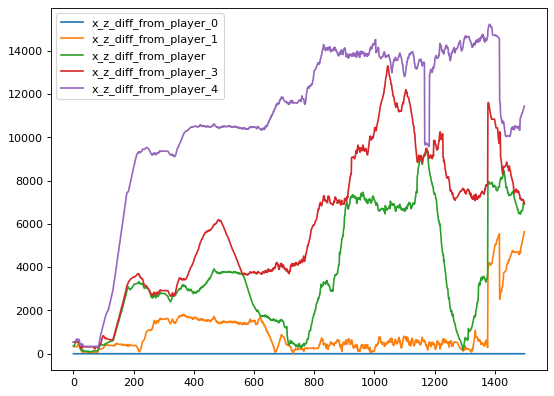

In [60]:
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt

figure(figsize=(8, 6), dpi=80)

# Plot Distances from Player
col_filter = ["x_z_diff" in c for c in allied_champs_df_base.columns]
x_z_diff_cols = list(compress(allied_champs_df_base.columns, col_filter))

for col in x_z_diff_cols:
    plt.plot(allied_champs_df_base[col], label=col)

plt.legend(loc="upper left")

#### Combine Enemy Champion Obs

In [61]:
enemy_champs_df.shape

(7495, 66)

In [62]:
enemy_team           = 100 if player_df.iloc[0]["team"] == 200 else 100
enemy_champs_df      = champs_df[champs_df["team"] == enemy_team]
enemy_champs_df      = enemy_champs_df.sort_values(["time", "x_z_diff_from_player"], ascending=True)
enemy_champs_df_     = enemy_champs_df
enemy_champs_df_base = enemy_champs_df.iloc[0::5, :]

drop_columns = ["obj_type", "obj_id", "net_id", "name", "q_name", "w_name", "e_name", "r_name", "d_name", "f_name"]
enemy_champs_df_base = enemy_champs_df_base.drop(labels=drop_columns, axis=1)
enemy_champs_df = enemy_champs_df.drop(labels=drop_columns, axis=1)

enemy_champ_count = 5
for i in range(1, enemy_champ_count):
    cur_enemy_champs_df  = enemy_champs_df.iloc[i::enemy_champ_count, :]
    enemy_champs_df_base = \
        enemy_champs_df_base.merge(
            cur_enemy_champs_df,
            on="time",
            suffixes=('_0' if i == 0 else '', f'_{i+1}'))

enemy_champs_df_base

,time,health,max_health,team,armour,mr,movement_speed,is_alive,position_x,position_y,...,f_prev_cd_5,q_cast_5,w_cast_5,e_cast_5,r_cast_5,d_cast_5,f_cast_5,x_diff_from_player_5,z_diff_from_player_5,x_z_diff_from_player_5
0,5.202038,600.000000,600.000000,100,42.000000,28.000000,690.625,1,590.000000,183.574799,...,0.000000,False,False,False,False,False,False,-14456.000000,-14052.000000,20160.224205
1,6.243157,600.000000,600.000000,100,42.000000,28.000000,690.625,1,590.000000,183.574799,...,10.797962,False,False,False,False,False,False,-14456.000000,-14052.000000,20160.224205
2,6.527338,600.000000,600.000000,100,42.000000,28.000000,690.625,1,590.000000,183.574799,...,9.756844,False,False,False,False,False,False,-14456.000000,-14052.000000,20160.224205
3,6.594130,600.000000,600.000000,100,42.000000,28.000000,690.625,1,590.000000,183.574799,...,9.472662,False,False,False,False,False,False,-14456.000000,-14052.000000,20160.224205
4,6.727624,600.000000,600.000000,100,42.000000,28.000000,690.625,1,590.000000,183.574799,...,9.405870,False,False,False,False,False,False,-14456.000000,-14052.000000,20160.224205
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1494,298.560089,722.174988,722.174988,100,35.162498,30.737499,355.000,1,12780.000000,51.366901,...,277.449341,False,False,False,False,False,False,-9658.447510,5791.354492,11261.678168
1495,298.878418,722.174988,722.174988,100,35.162498,30.737499,355.000,1,12750.000000,51.366901,...,277.112579,False,False,False,False,False,False,-9735.072266,5908.019043,11387.551143
1496,299.174561,722.174988,722.174988,100,35.162498,30.737499,355.000,1,12754.000000,51.366905,...,276.794250,False,False,False,False,False,False,-9802.851074,5954.294434,11469.503537
1497,299.462708,722.174988,722.174988,100,35.162498,30.737499,355.000,1,12800.427734,51.366901,...,276.498108,False,False,False,False,False,False,-9877.872559,6066.442871,11591.984101


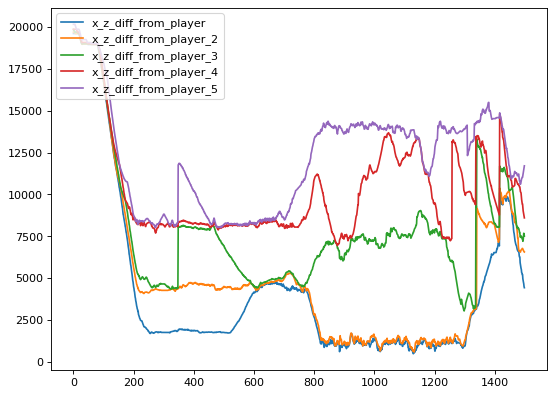

In [63]:
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=80)

# Plot Distances from Player
col_filter = ["x_z_diff" in c for c in enemy_champs_df_base.columns]
x_z_diff_cols = list(compress(enemy_champs_df_base.columns, col_filter))

for col in x_z_diff_cols:
    plt.plot(enemy_champs_df_base[col], label=col)

plt.legend(loc="upper left")

#### Combine All Champion Obs

In [64]:
combined_champs_df_base = \
    allied_champs_df_base.merge(
        enemy_champs_df_base,
        on="time",
        suffixes=('_', '__'))
        
combined_champs_df_base

,time,health_0,max_health_0,team_0,armour_0,mr_0,movement_speed_0,is_alive_0,position_x_0,position_y_0,...,f_prev_cd_5,q_cast_5,w_cast_5,e_cast_5,r_cast_5,d_cast_5,f_cast_5,x_diff_from_player_5,z_diff_from_player_5,x_z_diff_from_player_5
0,5.202038,610.000000,610.000000,200,32.000000,30.000000,676.875,1,14588.000000,171.977707,...,0.000000,False,False,False,False,False,False,-14456.000000,-14052.000000,20160.224205
1,6.243157,610.000000,610.000000,200,32.000000,30.000000,676.875,1,14588.000000,171.977707,...,10.797962,False,False,False,False,False,False,-14456.000000,-14052.000000,20160.224205
2,6.527338,610.000000,610.000000,200,32.000000,30.000000,676.875,1,14588.000000,171.977707,...,9.756844,False,False,False,False,False,False,-14456.000000,-14052.000000,20160.224205
3,6.594130,610.000000,610.000000,200,32.000000,30.000000,676.875,1,14588.000000,171.977707,...,9.472662,False,False,False,False,False,False,-14456.000000,-14052.000000,20160.224205
4,6.727624,610.000000,610.000000,200,32.000000,30.000000,676.875,1,14588.000000,171.977707,...,9.405870,False,False,False,False,False,False,-14456.000000,-14052.000000,20160.224205
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1494,298.560089,736.849976,736.849976,200,37.162498,30.737499,350.000,1,13731.624023,52.306301,...,277.449341,False,False,False,False,False,False,-9658.447510,5791.354492,11261.678168
1495,298.878418,736.849976,736.849976,200,37.162498,30.737499,350.000,1,13725.002930,52.306301,...,277.112579,False,False,False,False,False,False,-9735.072266,5908.019043,11387.551143
1496,299.174561,736.849976,736.849976,200,37.162498,30.737499,350.000,1,13719.792969,52.306301,...,276.794250,False,False,False,False,False,False,-9802.851074,5954.294434,11469.503537
1497,299.462708,736.849976,736.849976,200,37.162498,30.737499,350.000,1,13714.817383,52.306301,...,276.498108,False,False,False,False,False,False,-9877.872559,6066.442871,11591.984101


### Combine Object Obs

#### Combine Minion Obs

##### Combine Allied Minion Obs

In [78]:
import numpy as np

allied_minions_count = 30
allied_minions_df      = objects_df[\
    (objects_df["team"] == player_df.iloc[0]["team"]) &
    (objects_df["obj_type"] == "minions") &
    (objects_df["is_alive"] == 1)]
allied_minions_tms     = allied_minions_df["time"].value_counts().iloc[::-1]
allied_minions_df      = allied_minions_df.sort_values(["time", "x_z_diff_from_player"], ascending=True)
allied_minions_df_lst  = []

for i in range(len(allied_minions_tms)):
    # Get allied minion data for current timestep
    tm    = allied_minions_tms.index[i]
    count = allied_minions_tms.iloc[i]
    cur_data = allied_minions_df[allied_minions_df["time"] == tm]

    # Pad to desired amount (either up to 30 or down to 30)
    cur_data = cur_data.values.tolist()
    if count < allied_minions_count:
        cur_data_padding = [[tm] + [0] * 17] * (allied_minions_count - count)
        cur_data += cur_data_padding
    else:
        cur_data = cur_data[0:allied_minions_count]
    allied_minions_df_lst += cur_data

allied_minions_df_pre = \
    pd.DataFrame(
        allied_minions_df_lst,
        columns=allied_minions_df.columns)
allied_minions_df_pre = allied_minions_df_pre.drop(labels=["obj_type", "name", "obj_id", "net_id"], axis=1)

allied_minions_df_base = allied_minions_df_pre.iloc[0::allied_minions_count, :]

for i in range(1, allied_minions_count):
    cur_allied_minions_df  = allied_minions_df_pre.iloc[i::allied_minions_count, :]
    allied_minions_df_base = \
        allied_minions_df_base.merge(
            cur_allied_minions_df,
            on="time",
            how="left",
            suffixes=('_0' if i == 0 else '', f'_{i+1}'))

allied_minions_df_base

,time,health,max_health,team,armour,mr,movement_speed,is_alive,position_x,position_y,...,position_x_30,position_y_30,position_z_30,is_moving_30,targetable_30,invulnerable_30,recallState_30,x_diff_from_player_30,z_diff_from_player_30,x_z_diff_from_player_30
0,65.058548,477.000000,477.0,200,0.0,0.0,0.0,1,12755.088867,91.429810,...,0.000000,0.000000,0.000000,0,0,0,NaN,NaN,NaN,NaN
1,65.772957,477.000000,477.0,200,0.0,0.0,325.0,1,12658.365234,91.429810,...,0.000000,0.000000,0.000000,0,0,0,NaN,NaN,NaN,NaN
2,65.639465,477.000000,477.0,200,0.0,0.0,325.0,1,12677.709961,91.429810,...,0.000000,0.000000,0.000000,0,0,0,NaN,NaN,NaN,NaN
3,65.238976,477.000000,477.0,200,0.0,0.0,0.0,1,12755.088867,91.429810,...,0.000000,0.000000,0.000000,0,0,0,NaN,NaN,NaN,NaN
4,65.439232,477.000000,477.0,200,0.0,0.0,325.0,1,12716.399414,91.429810,...,0.000000,0.000000,0.000000,0,0,0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
942,191.882385,302.000000,302.0,200,0.0,0.0,325.0,1,13295.692383,51.366901,...,11074.529297,91.429779,13421.623047,1,1,0,0.0,-2175.162109,9505.893066,9751.581061
943,192.180130,302.000000,302.0,200,0.0,0.0,325.0,1,13240.349609,51.366901,...,10978.600586,91.429779,13420.253906,1,1,0,0.0,-2247.399414,9540.253906,9801.390142
944,192.486267,230.104889,302.0,200,0.0,0.0,325.0,1,13165.550781,51.366901,...,10881.103516,91.429779,13420.933594,1,1,0,0.0,-2333.416992,9577.058105,9857.224600
945,158.899414,296.000000,296.0,200,0.0,0.0,325.0,1,13588.122070,52.042168,...,3490.588867,52.838100,13435.117188,1,1,0,0.0,-10195.871094,9283.219727,13788.906985


##### Combine Enemy Minion Obs

In [82]:
import numpy as np

enemy_minions_count   = 30
enemy_team            = 100 if player_df.iloc[0]["team"] == 200 else 100
enemy_minions_df      = objects_df[\
    (objects_df["team"] == enemy_team) &
    (objects_df["obj_type"] == "minions")]
    # NOTE: THIS WAS REMOVED TO FIX TIMING ISSUES WHEN ISSUING LAST HIT ON MINIONS
    # (objects_df["is_alive"] == 1)
enemy_minions_tms     = enemy_minions_df["time"].value_counts().iloc[::-1]
enemy_minions_df      = enemy_minions_df.sort_values(["time", "x_z_diff_from_player"], ascending=True)
enemy_minions_df_lst  = []

for i in range(len(enemy_minions_tms)):
    # Get enemy minion data for current timestep
    tm    = enemy_minions_tms.index[i]
    count = enemy_minions_tms.iloc[i]
    cur_data = enemy_minions_df[enemy_minions_df["time"] == tm]

    # Pad to desired amount (either up to 30 or down to 30)
    cur_data = cur_data.values.tolist()
    if count < enemy_minions_count:
        cur_data_padding = [[tm] + [0] * 17] * (enemy_minions_count - count)
        cur_data += cur_data_padding
    else:
        cur_data = cur_data[0:enemy_minions_count]
    enemy_minions_df_lst += cur_data

enemy_minions_df_pre = \
    pd.DataFrame(
        enemy_minions_df_lst,
        columns=enemy_minions_df.columns)
enemy_minions_df_pre = enemy_minions_df_pre.drop(labels=["obj_type", "name", "obj_id", "net_id"], axis=1)

enemy_minions_df_base = enemy_minions_df_pre.iloc[0::enemy_minions_count, :]

for i in range(1, enemy_minions_count):
    cur_enemy_minions_df  = enemy_minions_df_pre.iloc[i::enemy_minions_count, :]
    enemy_minions_df_base = \
        enemy_minions_df_base.merge(
            cur_enemy_minions_df,
            on="time",
            suffixes=('_0' if i == 0 else '', f'_{i+1}'))

enemy_minions_df_base

,time,health,max_health,team,armour,mr,movement_speed,is_alive,position_x,position_y,...,position_x_30,position_y_30,position_z_30,is_moving_30,targetable_30,invulnerable_30,recallState_30,x_diff_from_player_30,z_diff_from_player_30,x_z_diff_from_player_30
0,65.058548,477.0,477.0,100,0.0,0.0,0.0,1,2026.157837,95.748055,...,0.000000,0.000000,0.000000,0,0,0,NaN,NaN,NaN,NaN
1,65.305740,477.0,477.0,100,0.0,0.0,325.0,1,2044.373413,95.748047,...,0.000000,0.000000,0.000000,0,0,0,NaN,NaN,NaN,NaN
2,65.439232,477.0,477.0,100,0.0,0.0,325.0,1,2062.588867,95.748047,...,0.000000,0.000000,0.000000,0,0,0,NaN,NaN,NaN,NaN
3,65.505974,477.0,477.0,100,0.0,0.0,325.0,1,2080.804443,95.748047,...,0.000000,0.000000,0.000000,0,0,0,NaN,NaN,NaN,NaN
4,65.639465,477.0,477.0,100,0.0,0.0,325.0,1,2099.020020,95.748047,...,0.000000,0.000000,0.000000,0,0,0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
942,249.610672,280.0,302.0,100,0.0,0.0,325.0,1,13055.560547,51.366901,...,1442.849121,95.748039,3614.784668,1,1,0,0.0,-11735.312988,802.504883,11762.720137
943,249.290527,302.0,302.0,100,0.0,0.0,325.0,1,13055.560547,51.366901,...,1447.424561,95.748077,3517.392334,1,1,0,0.0,-11664.713135,779.009766,11690.696674
944,250.577087,247.0,302.0,100,0.0,0.0,325.0,1,13055.560547,51.366901,...,1444.802856,95.748047,3319.215820,1,1,0,0.0,-11850.998901,293.479980,11854.632236
945,250.871597,247.0,302.0,100,0.0,0.0,325.0,1,13055.560547,51.366901,...,1447.424561,95.748077,3517.392334,1,1,0,0.0,-11828.440674,412.890381,11835.644775


##### Combine All Minion Obs

In [83]:
combined_minions_df_base = \
    allied_minions_df_base.merge(
        enemy_minions_df_base,
        on="time",
        suffixes=('_', '__'))
        
combined_minions_df_base

,time,health_,max_health_,team_,armour_,mr_,movement_speed_,is_alive_,position_x_,position_y_,...,position_x_30__,position_y_30__,position_z_30__,is_moving_30__,targetable_30__,invulnerable_30__,recallState_30__,x_diff_from_player_30__,z_diff_from_player_30__,x_z_diff_from_player_30__
0,65.058548,477.000000,477.0,200,0.0,0.0,0.0,1,12755.088867,91.429810,...,0.000000,0.000000,0.000000,0,0,0,NaN,NaN,NaN,NaN
1,65.772957,477.000000,477.0,200,0.0,0.0,325.0,1,12658.365234,91.429810,...,0.000000,0.000000,0.000000,0,0,0,NaN,NaN,NaN,NaN
2,65.639465,477.000000,477.0,200,0.0,0.0,325.0,1,12677.709961,91.429810,...,0.000000,0.000000,0.000000,0,0,0,NaN,NaN,NaN,NaN
3,65.238976,477.000000,477.0,200,0.0,0.0,0.0,1,12755.088867,91.429810,...,0.000000,0.000000,0.000000,0,0,0,NaN,NaN,NaN,NaN
4,65.439232,477.000000,477.0,200,0.0,0.0,325.0,1,12716.399414,91.429810,...,0.000000,0.000000,0.000000,0,0,0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
942,191.882385,302.000000,302.0,200,0.0,0.0,325.0,1,13295.692383,51.366901,...,1375.908081,95.748016,3098.985596,1,1,0,0.0,-11873.783325,-816.744385,11901.840271
943,192.180130,302.000000,302.0,200,0.0,0.0,325.0,1,13240.349609,51.366901,...,1398.619751,95.748047,4556.247559,1,1,0,0.0,-11827.380249,676.247559,11846.697190
944,192.486267,230.104889,302.0,200,0.0,0.0,325.0,1,13165.550781,51.366901,...,1394.044067,95.748047,4653.640625,1,1,0,0.0,-11820.476440,809.765137,11848.180572
945,158.899414,296.000000,296.0,200,0.0,0.0,325.0,1,13588.122070,52.042168,...,1369.363525,95.748016,3074.261719,1,1,0,0.0,-12317.096436,-1077.635742,12364.148309


#### Combine Turret Obs

##### Combine Allied Turret Obs

In [84]:
import numpy as np

allied_turrets_count   = 11
allied_turrets_df      = objects_df[\
    (objects_df["team"] == player_df.iloc[0]["team"]) &
    (objects_df["obj_type"] == "turrets")]
allied_turrets_tms     = allied_turrets_df["time"].value_counts().iloc[::-1]
allied_turrets_df      = allied_turrets_df.sort_values(["time", "x_z_diff_from_player"], ascending=True)
allied_turrets_df_lst  = []

for i in range(len(allied_turrets_tms)):
    # Get allied minion data for current timestep
    tm    = allied_turrets_tms.index[i]
    count = allied_turrets_tms.iloc[i]
    cur_data = allied_turrets_df[allied_turrets_df["time"] == tm]

    # Pad to desired amount (either up to 30 or down to 30)
    cur_data = cur_data.values.tolist()
    if count < allied_turrets_count:
        cur_data_padding = [[tm] + [0] * 17] * (allied_turrets_count - count)
        cur_data += cur_data_padding
    else:
        cur_data = cur_data[0:allied_turrets_count]
    allied_turrets_df_lst += cur_data

allied_turrets_df_pre = \
    pd.DataFrame(
        allied_turrets_df_lst,
        columns=allied_turrets_df.columns)
allied_turrets_df_pre = allied_turrets_df_pre.drop(labels=["obj_type", "name", "obj_id", "net_id"], axis=1)

allied_turrets_df_base = allied_turrets_df_pre.iloc[0::allied_turrets_count, :]

for i in range(1, allied_turrets_count):
    cur_allied_turrets_df  = allied_minions_df_pre.iloc[i::allied_minions_count, :]
    allied_turrets_df_base = \
        allied_turrets_df_base.merge(
            cur_allied_turrets_df,
            on="time",
            suffixes=('_0' if i == 0 else '', f'_{i+1}'))

allied_turrets_df_base

,time,health,max_health,team,armour,mr,movement_speed,is_alive,position_x,position_y,...,position_x_11,position_y_11,position_z_11,is_moving_11,targetable_11,invulnerable_11,recallState_11,x_diff_from_player_11,z_diff_from_player_11,x_z_diff_from_player_11
0,299.743866,3600.000000,3600.0,200,55.0,55.0,0.0,1,13327.0,38.0,...,7515.613281,53.503189,7403.160156,1,1,0,0.0,-6194.368164,-157.912598,6196.380665
1,65.058548,5000.000000,5000.0,200,15.0,15.0,0.0,1,13866.0,38.0,...,0.000000,0.000000,0.000000,0,0,0,NaN,NaN,NaN,NaN
2,65.238976,5000.000000,5000.0,200,15.0,15.0,0.0,1,13866.0,38.0,...,0.000000,0.000000,0.000000,0,0,0,NaN,NaN,NaN,NaN
3,65.305740,5000.000000,5000.0,200,15.0,15.0,0.0,1,13866.0,38.0,...,0.000000,0.000000,0.000000,0,0,0,NaN,NaN,NaN,NaN
4,65.439232,5000.000000,5000.0,200,15.0,15.0,0.0,1,13866.0,38.0,...,0.000000,0.000000,0.000000,0,0,0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
942,159.628311,4515.524902,5000.0,200,15.0,15.0,0.0,1,13866.0,38.0,...,13322.898438,91.429840,11240.154297,1,1,0,0.0,-271.010742,7223.641602,7228.723595
943,159.965591,4515.524902,5000.0,200,15.0,15.0,0.0,1,13866.0,38.0,...,13326.235352,91.429840,11142.710938,1,1,0,0.0,-199.024414,7190.913086,7193.666779
944,160.274338,4515.524902,5000.0,200,15.0,15.0,0.0,1,13866.0,38.0,...,13326.235352,91.429840,11142.710938,1,1,0,0.0,-199.024414,7190.913086,7193.666779
945,160.584091,4515.524902,5000.0,200,15.0,15.0,0.0,1,13866.0,38.0,...,7252.000000,54.343918,7430.000000,1,1,0,0.0,-6124.670898,3557.196045,7082.742217


##### Combine Enemy Turret Obs

In [85]:
enemy_turrets_df_pre.shape

(16489, 18)

In [86]:
import numpy as np

enemy_turrets_count   = 11
enemy_team            = 100 if player_df.iloc[0]["team"] == 200 else 100
enemy_turrets_df      = objects_df[\
    (objects_df["team"] == enemy_team) &
    (objects_df["obj_type"] == "turrets")]
enemy_turrets_tms     = enemy_turrets_df["time"].value_counts().iloc[::-1]
enemy_turrets_df      = enemy_turrets_df.sort_values(["time", "x_z_diff_from_player"], ascending=True)
enemy_turrets_df_lst  = []

for i in range(len(enemy_turrets_tms)):
    # Get allied minion data for current timestep
    tm    = enemy_turrets_tms.index[i]
    count = enemy_turrets_tms.iloc[i]
    cur_data = enemy_turrets_df[enemy_turrets_df["time"] == tm]

    # Pad to desired amount (either up to 30 or down to 30)
    cur_data = cur_data.values.tolist()
    if count < enemy_turrets_count:
        cur_data_padding = [[tm] + [0] * 17] * (enemy_turrets_count - count)
        cur_data += cur_data_padding
    else:
        cur_data = cur_data[0:enemy_turrets_count]
    enemy_turrets_df_lst += cur_data

enemy_turrets_df_pre = \
    pd.DataFrame(
        enemy_turrets_df_lst,
        columns=enemy_turrets_df.columns)
enemy_turrets_df_pre = enemy_turrets_df_pre.drop(labels=["obj_type", "name", "obj_id", "net_id"], axis=1)

enemy_turrets_df_base = enemy_turrets_df_pre.iloc[0::enemy_turrets_count, :]

for i in range(1, enemy_turrets_count):
    cur_enemy_turrets_df  = allied_minions_df_pre.iloc[i::allied_minions_count, :]
    enemy_turrets_df_base = \
        enemy_turrets_df_base.merge(
            cur_enemy_turrets_df,
            on="time",
            suffixes=('_0' if i == 0 else '', f'_{i+1}'))

enemy_turrets_df_base

,time,health,max_health,team,armour,mr,movement_speed,is_alive,position_x,position_y,...,position_x_11,position_y_11,position_z_11,is_moving_11,targetable_11,invulnerable_11,recallState_11,x_diff_from_player_11,z_diff_from_player_11,x_z_diff_from_player_11
0,299.743866,5000.0,5000.0,100,15.0,15.0,0.0,1,10504.0,41.0,...,7515.613281,53.503189,7403.160156,1,1,0,0.0,-6194.368164,-157.912598,6196.380665
1,65.058548,5000.0,5000.0,100,15.0,15.0,0.0,1,10504.0,41.0,...,0.000000,0.000000,0.000000,0,0,0,NaN,NaN,NaN,NaN
2,65.238976,5000.0,5000.0,100,15.0,15.0,0.0,1,10504.0,41.0,...,0.000000,0.000000,0.000000,0,0,0,NaN,NaN,NaN,NaN
3,65.305740,5000.0,5000.0,100,15.0,15.0,0.0,1,10504.0,41.0,...,0.000000,0.000000,0.000000,0,0,0,NaN,NaN,NaN,NaN
4,65.439232,5000.0,5000.0,100,15.0,15.0,0.0,1,10504.0,41.0,...,0.000000,0.000000,0.000000,0,0,0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
942,159.628311,5000.0,5000.0,100,15.0,15.0,0.0,1,10504.0,41.0,...,13322.898438,91.429840,11240.154297,1,1,0,0.0,-271.010742,7223.641602,7228.723595
943,159.965591,5000.0,5000.0,100,15.0,15.0,0.0,1,10504.0,41.0,...,13326.235352,91.429840,11142.710938,1,1,0,0.0,-199.024414,7190.913086,7193.666779
944,160.274338,5000.0,5000.0,100,15.0,15.0,0.0,1,10504.0,41.0,...,13326.235352,91.429840,11142.710938,1,1,0,0.0,-199.024414,7190.913086,7193.666779
945,160.584091,5000.0,5000.0,100,15.0,15.0,0.0,1,10504.0,41.0,...,7252.000000,54.343918,7430.000000,1,1,0,0.0,-6124.670898,3557.196045,7082.742217


##### Combine All Turrets Obs

In [87]:
combined_turrets_df_base = \
    allied_turrets_df_base.merge(
        enemy_turrets_df_base,
        on="time",
        suffixes=('_', '__'))
        
combined_turrets_df_base

,time,health_,max_health_,team_,armour_,mr_,movement_speed_,is_alive_,position_x_,position_y_,...,position_x_11__,position_y_11__,position_z_11__,is_moving_11__,targetable_11__,invulnerable_11__,recallState_11__,x_diff_from_player_11__,z_diff_from_player_11__,x_z_diff_from_player_11__
0,299.743866,3600.000000,3600.0,200,55.0,55.0,0.0,1,13327.0,38.0,...,7515.613281,53.503189,7403.160156,1,1,0,0.0,-6194.368164,-157.912598,6196.380665
1,65.058548,5000.000000,5000.0,200,15.0,15.0,0.0,1,13866.0,38.0,...,0.000000,0.000000,0.000000,0,0,0,NaN,NaN,NaN,NaN
2,65.238976,5000.000000,5000.0,200,15.0,15.0,0.0,1,13866.0,38.0,...,0.000000,0.000000,0.000000,0,0,0,NaN,NaN,NaN,NaN
3,65.305740,5000.000000,5000.0,200,15.0,15.0,0.0,1,13866.0,38.0,...,0.000000,0.000000,0.000000,0,0,0,NaN,NaN,NaN,NaN
4,65.439232,5000.000000,5000.0,200,15.0,15.0,0.0,1,13866.0,38.0,...,0.000000,0.000000,0.000000,0,0,0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
942,159.628311,4515.524902,5000.0,200,15.0,15.0,0.0,1,13866.0,38.0,...,13322.898438,91.429840,11240.154297,1,1,0,0.0,-271.010742,7223.641602,7228.723595
943,159.965591,4515.524902,5000.0,200,15.0,15.0,0.0,1,13866.0,38.0,...,13326.235352,91.429840,11142.710938,1,1,0,0.0,-199.024414,7190.913086,7193.666779
944,160.274338,4515.524902,5000.0,200,15.0,15.0,0.0,1,13866.0,38.0,...,13326.235352,91.429840,11142.710938,1,1,0,0.0,-199.024414,7190.913086,7193.666779
945,160.584091,4515.524902,5000.0,200,15.0,15.0,0.0,1,13866.0,38.0,...,7252.000000,54.343918,7430.000000,1,1,0,0.0,-6124.670898,3557.196045,7082.742217


#### Combine Jungle Obs

In [88]:
import numpy as np

jungle_count   = 24
jungle_df      = objects_df[\
    (objects_df["obj_type"] == "jungle") &
    (objects_df["is_alive"] == 1)]
jungle_tms     = jungle_df["time"].value_counts().iloc[::-1]
jungle_df      = jungle_df.sort_values(["time", "x_z_diff_from_player"], ascending=True)
jungle_df_lst  = []

for i in range(len(jungle_tms)):
    # Get allied minion data for current timestep
    tm    = jungle_tms.index[i]
    count = jungle_tms.iloc[i]
    cur_data = jungle_df[jungle_df["time"] == tm]

    # Pad to desired amount (either up to 30 or down to 30)
    cur_data = cur_data.values.tolist()
    if count < jungle_count:
        cur_data_padding = [[tm] + [0] * 17] * (jungle_count - count)
        cur_data += cur_data_padding
    else:
        cur_data = cur_data[0:jungle_count]
    jungle_df_lst += cur_data

jungle_df_pre = \
    pd.DataFrame(
        jungle_df_lst,
        columns=jungle_df.columns)
jungle_df_pre_ = jungle_df_pre
jungle_df_pre = jungle_df_pre.drop(labels=["obj_type", "name", "obj_id", "net_id"], axis=1)

jungle_df_base = jungle_df_pre.iloc[0::jungle_count, :]

for i in range(1, jungle_count):
    cur_jungle_df  = jungle_df_pre.iloc[i::jungle_count, :]
    jungle_df_base = \
        jungle_df_base.merge(
            cur_jungle_df,
            on="time",
            suffixes=('_0' if i == 0 else '', f'_{i+1}'))

combined_jungle_df_base = jungle_df_base
combined_jungle_df_base

,time,health,max_health,team,armour,mr,movement_speed,is_alive,position_x,position_y,...,position_x_24,position_y_24,position_z_24,is_moving_24,targetable_24,invulnerable_24,recallState_24,x_diff_from_player_24,z_diff_from_player_24,x_z_diff_from_player_24
0,88.257690,1850.0,1850.0,300,20.0,20.0,275.0,1,7765.244141,53.956444,...,0.000000,0.000000,0.000000,0,0,0,NaN,NaN,NaN,NaN
1,88.665352,1850.0,1850.0,300,20.0,20.0,275.0,1,7765.244141,53.956444,...,0.000000,0.000000,0.000000,0,0,0,NaN,NaN,NaN,NaN
2,88.792984,1850.0,1850.0,300,20.0,20.0,275.0,1,7765.244141,53.956444,...,0.000000,0.000000,0.000000,0,0,0,NaN,NaN,NaN,NaN
3,88.533035,1850.0,1850.0,300,20.0,20.0,275.0,1,7765.244141,53.956444,...,0.000000,0.000000,0.000000,0,0,0,NaN,NaN,NaN,NaN
4,88.922966,1850.0,1850.0,300,0.0,0.0,0.0,1,11031.728516,51.723640,...,0.000000,0.000000,0.000000,0,0,0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
774,101.462242,1650.0,1650.0,300,20.0,20.0,330.0,1,12703.628906,51.690784,...,3730.627930,52.461395,6593.983887,1,1,0,0.0,-8847.154297,984.935547,8901.810894
775,101.253616,1650.0,1650.0,300,20.0,20.0,330.0,1,12703.628906,51.690784,...,3730.627930,52.461395,6593.983887,1,1,0,0.0,-8828.514648,929.579102,8877.318751
776,101.077141,1650.0,1650.0,300,20.0,20.0,330.0,1,12703.628906,51.690784,...,3730.627930,52.461395,6593.983887,1,1,0,0.0,-8802.914062,866.793457,8845.486244
777,104.347610,1650.0,1650.0,300,20.0,20.0,330.0,1,12703.628906,51.690784,...,3821.488525,52.035931,7901.054199,1,1,0,0.0,-9245.712646,3003.546875,9721.342303


#### Combine Other Obs

In [89]:
import numpy as np

other_count   = 5
other_df      = objects_df[\
    (objects_df["obj_type"] == "other") &
    (objects_df["name"] == "yellowtrinket") &
    (objects_df["is_alive"] == 1)]
other_tms     = other_df["time"].value_counts().iloc[::-1]
other_df      = other_df.sort_values(["time", "x_z_diff_from_player"], ascending=True)
other_df_lst  = []

for i in range(len(other_tms)):
    # Get allied minion data for current timestep
    tm    = other_tms.index[i]
    count = other_tms.iloc[i]
    cur_data = other_df[other_df["time"] == tm]

    # Pad to desired amount (either up to 30 or down to 30)
    cur_data = cur_data.values.tolist()
    if count < other_count:
        cur_data_padding = [[tm] + [0] * 17] * (other_count - count)
        cur_data += cur_data_padding
    else:
        cur_data = cur_data[0:other_count]
    other_df_lst += cur_data

other_df_pre = \
    pd.DataFrame(
        other_df_lst,
        columns=other_df.columns)
other_df_pre = other_df_pre.drop(labels=["obj_type", "name", "obj_id", "net_id"], axis=1)

other_df_base = other_df_pre.iloc[0::other_count, :]

for i in range(1, other_count):
    cur_other_df  = other_df_pre.iloc[i::other_count, :]
    other_df_base = \
        other_df_base.merge(
            cur_other_df,
            on="time",
            suffixes=('_0' if i == 0 else '', f'_{i+1}'))

combined_other_df_base = other_df_base

### Combine Missile Obs

In [90]:
import numpy as np

missile_count   = 30
missile_df      = missiles_df[\
    (missiles_df["obj_type"] == "missiles") &
    (missiles_df["is_alive"] == 1)]
missile_tms     = missile_df["time"].value_counts().iloc[::-1]
missile_df      = missile_df.sort_values(["time", "x_z_diff_from_player"], ascending=True)
missile_df_lst  = []

for i in range(len(missile_tms)):
    # Get allied minion data for current timestep
    tm    = missile_tms.index[i]
    count = missile_tms.iloc[i]
    cur_data = missile_df[missile_df["time"] == tm]

    # Pad to desired amount (either up to 30 or down to 30)
    cur_data = cur_data.values.tolist()
    if count < missile_count:
        cur_data_padding = [[tm] + [0] * 17] * (missile_count - count)
        cur_data += cur_data_padding
    else:
        cur_data = cur_data[0:missile_count]
    missile_df_lst += cur_data

missile_df_pre = \
    pd.DataFrame(
        missile_df_lst,
        columns=missile_df.columns)
missile_df_pre = missile_df_pre.drop(labels=["obj_type", "name", "obj_id", "net_id"], axis=1)

missile_df_base = missile_df_pre.iloc[0::missile_count, :]

for i in range(1, missile_count):
    cur_missile_df  = missile_df_pre.iloc[i::missile_count, :]
    missile_df_base = \
        missile_df_base.merge(
            cur_missile_df,
            on="time",
            suffixes=('_0' if i == 0 else '', f'_{i+1}'))

combined_missile_df_base = missile_df_base
combined_missile_df_base

,time,health,max_health,team,armour,mr,movement_speed,is_alive,position_x,position_y,...,start_position_y_30,start_position_z_30,end_position_x_30,end_position_y_30,end_position_z_30,source_idx_30,destination_idx_30,x_diff_from_player_30,z_diff_from_player_30,x_z_diff_from_player_30
0,88.533035,-5.621348e-03,-2.353774e-03,100,0.000000e+00,0.000000e+00,0.000000e+00,1,7445.472656,169.125336,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,120.079193,-1.244114e+13,-1.108504e+21,100,-9.980893e+27,-5.504300e-41,1.401298e-45,1,6725.910645,112.405579,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,147.489532,2.239555e-41,-2.526541e-42,200,-3.841030e-31,-1.464077e-41,1.952642e+02,1,13804.569336,623.922302,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,99.799355,-5.375138e-32,1.787778e+34,100,1.927405e-31,1.334877e-01,0.000000e+00,1,7421.399414,118.065758,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,99.627457,-5.375138e-32,1.787778e+34,100,1.927405e-31,1.334877e-01,0.000000e+00,1,7330.206543,122.906456,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
767,156.897675,0.000000e+00,0.000000e+00,200,1.000000e+00,1.000000e+00,1.000000e+00,1,13667.285156,104.616150,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
768,169.586929,-9.870391e-32,2.633496e-30,200,2.942212e+15,2.498627e-04,1.401298e-45,1,13084.692383,151.366898,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
769,166.466599,0.000000e+00,0.000000e+00,100,9.143613e-41,0.000000e+00,0.000000e+00,1,12953.620117,166.166229,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
770,265.018951,-3.313802e-03,0.000000e+00,200,9.077569e+15,1.270200e+04,5.169043e+01,1,13171.232422,93.643135,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Combine All Obs

In [91]:
combined_champs_df_base.shape, combined_minions_df_base.shape, combined_turrets_df_base.shape, combined_jungle_df_base.shape

((1499, 651), (947, 1021), (947, 375), (779, 409))

In [92]:
combined_df_base = \
    combined_champs_df_base.merge(
        combined_minions_df_base,
        on="time",
        how="left",
        suffixes=('_', '__'))
combined_df_base = \
    combined_df_base.merge(
        combined_turrets_df_base,
        on="time",
        how="left",
        suffixes=('_', '__'))
combined_df_base = \
    combined_df_base.merge(
        combined_jungle_df_base,
        on="time",
        how="left",
        suffixes=('_', '__'))
combined_df_base = \
    combined_df_base.merge(
        combined_other_df_base,
        on="time",
        how="left",
        suffixes=('_', '__'))
combined_df_base = \
    combined_df_base.merge(
        combined_missile_df_base,
        on="time",
        how="left",
        suffixes=('_', '__'))

combined_df_base = combined_df_base.fillna(0)
combined_df_base

C:\Users\win8t\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\frame.py:9190: FutureWarning: Passing 'suffixes' which cause duplicate columns {'z_diff_from_player_4___', 'x_diff_from_player_4___', 'position_z_3___', 'team___', 'armour_4___', 'position_y_3___', 'position_y___', 'armour_3___', 'is_alive_3___', 'targetable_3___', 'mr___', 'x_diff_from_player_3___', 'is_moving___', 'position_x___', 'position_x_3___', 'max_health_4___', 'position_y_4___', 'is_alive_4___', 'position_z_4___', 'invulnerable___', 'movement_speed_3___', 'x_diff_from_player___', 'movement_speed___', 'x_z_diff_from_player_3___', 'mr_3___', 'max_health_3___', 'health___', 'z_diff_from_player_3___', 'z_diff_from_player___', 'recallState___', 'mr_4___', 'team_3___', 'health_3___', 'invulnerable_4___', 'invulnerable_3___', 'x_z_diff_from_player_4___', 'team_4___', 'position_x_4___', 'is_alive___', 'targetable_4___', 'is_moving_4___', 'movement_speed_4___', 'recallState_3___', 'armour___', 'recallS

### Append Global

#### Append Minion Spawn Times

In [51]:
first_minion_spawn = 60 + 5 # 1 minute 5 seconds is when minions spawn
minion_spawn_times = combined_df_base["time"].apply(\
    lambda tm: 30 - ((tm - first_minion_spawn) % 30)
               if tm >= first_minion_spawn
               else first_minion_spawn - tm)
combined_df_base.insert(1, "minion_spawn_countdown", minion_spawn_times)
combined_df_base

,time,minion_spawn_countdown,health_0,max_health_0,team_0,armour_0,mr_0,movement_speed_0,is_alive_0,position_x_0,...,start_position_y_30,start_position_z_30,end_position_x_30,end_position_y_30,end_position_z_30,source_idx_30,destination_idx_30,x_diff_from_player_30,z_diff_from_player_30,x_z_diff_from_player_30
0,5.202038,59.797962,610.000000,610.000000,200,32.000000,30.000000,676.875,1,14588.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,6.243157,58.756843,610.000000,610.000000,200,32.000000,30.000000,676.875,1,14588.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,6.527338,58.472662,610.000000,610.000000,200,32.000000,30.000000,676.875,1,14588.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6.594130,58.405870,610.000000,610.000000,200,32.000000,30.000000,676.875,1,14588.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,6.727624,58.272376,610.000000,610.000000,200,32.000000,30.000000,676.875,1,14588.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1494,298.560089,6.439911,736.849976,736.849976,200,37.162498,30.737499,350.000,1,13731.624023,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1495,298.878418,6.121582,736.849976,736.849976,200,37.162498,30.737499,350.000,1,13725.002930,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1496,299.174561,5.825439,736.849976,736.849976,200,37.162498,30.737499,350.000,1,13719.792969,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1497,299.462708,5.537292,736.849976,736.849976,200,37.162498,30.737499,350.000,1,13714.817383,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Combine Actions

#### Combine Auto Attacks

In [52]:
from itertools import compress

valid_aa_missile_dst_s = aa_missile_dst_s[aa_missile_dst_s["target_id"] != -1]
auto_attack_df_base    = valid_aa_missile_dst_s[["time", "x_diff_from_player", "z_diff_from_player", "x_z_diff_from_player", "target_type", "target_id"]]

def get_target_idx(row):
    tm          = row["time"]
    target_type = row["target_type"]
    target_id   = row["target_id"]
    if target_type == "champs":
        cur_units  = enemy_champs_df_[\
            enemy_champs_df_["time"] == tm]
        cur_units  = cur_units.sort_values(["time", "x_z_diff_from_player"], ascending=True)
        cur_units  = cur_units[
            (cur_units["obj_type"] != 0)]
        target_idx = cur_units[cur_units["net_id"] == target_id].index
        target_idx = list(cur_units.index).index(target_idx) + 1
        return target_idx
    elif target_type == "minions":
        cur_units  = enemy_minions_df[\
            enemy_minions_df["time"] == tm]
        cur_units  = cur_units.sort_values(["time", "x_z_diff_from_player"], ascending=True)
        cur_units  = cur_units[
            (cur_units["obj_type"] != 0)]
        target_idx = cur_units[cur_units["net_id"] == target_id].index
        target_idx = list(cur_units.index).index(target_idx) + 1
        return target_idx
    elif target_type == "jungle":
        cur_units  = jungle_df_pre_[\
            jungle_df_pre_["time"] == tm]
        cur_units  = cur_units.sort_values(["time", "x_z_diff_from_player"], ascending=True)
        cur_units  = cur_units[
            (cur_units["obj_type"] != 0)]
        target_idx = cur_units[cur_units["net_id"] == target_id].index
        target_idx = list(cur_units.index).index(target_idx) + 1
        return target_idx
    elif target_type == "turrets":
        cur_units  = enemy_turrets_df[\
            enemy_turrets_df["time"] == tm]
        cur_units  = cur_units.sort_values(["time", "x_z_diff_from_player"], ascending=True)
        cur_units  = cur_units[
            (cur_units["obj_type"] != 0)]
        target_idx = cur_units[cur_units["net_id"] == target_id].index
        target_idx = list(cur_units.index).index(target_idx) + 1
        return target_idx
    return 0

target_idx = auto_attack_df_base.apply(lambda row: get_target_idx(row), axis=1)

target_idx

19      1
25      1
62      1
66      1
98      1
       ..
6469    2
6540    3
6787    2
7033    4
7177    3
Length: 73, dtype: int64

In [53]:
target_type_enum = ["champs", "minions", "turrets", "jungle", "other"]
auto_attack_df_base = aa_missile_dst_s[["time", "target_type"]]
auto_attack_df_base["target_idx"] = target_idx
auto_attack_df_base["target_type"] = \
    auto_attack_df_base["target_type"].apply(\
        lambda target_type_str: \
            target_type_enum.index(target_type_str)
            if target_type_str in target_type_enum
            else -1)
auto_attack_df_base["using_auto"] = 1
auto_attack_df_base = auto_attack_df_base.dropna()
auto_attack_df_base

C:\Users\win8t\AppData\Local\Temp/ipykernel_19256/4224686363.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  auto_attack_df_base["target_idx"] = target_idx
C:\Users\win8t\AppData\Local\Temp/ipykernel_19256/4224686363.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  auto_attack_df_base["target_type"] = \
C:\Users\win8t\AppData\Local\Temp/ipykernel_19256/4224686363.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

,time,target_type,target_idx,using_auto
19,90.580360,3,1.0,1
25,90.740250,3,1.0,1
62,91.995224,3,1.0,1
66,92.140221,3,1.0,1
98,93.283470,3,1.0,1
...,...,...,...,...
6469,250.577087,1,2.0,1
6540,252.244934,1,3.0,1
6787,257.161591,1,2.0,1
7033,262.915649,1,4.0,1


#### Combine Spells

##### Combine Q Spell

In [54]:
q_spell_df_base = player_df[player_df["q_cast"] == True]
q_spell_df_base = q_spell_df_base[["time"]]
q_spell_df_base["using_q"] = 1
q_spell_df_base

,time,using_q
9020,113.726471,1
10014,134.624039,1
11367,162.747101,1
11609,167.959061,1
11928,174.957443,1
12005,176.546799,1
12115,178.894806,1
12324,182.800278,1
12632,189.283112,1
12764,192.180130,1


##### Combine W Spell

In [55]:
w_spell_df_base = missiles_df[missiles_df.index.isin(w_missiles)]
w_spell_df_base = w_spell_df_base[["time", "x_diff_from_player", "z_diff_from_player"]]

pos_x_delta_digital = \
    w_spell_df_base["x_diff_from_player"].apply(lambda val: digitize_delta(val))
pos_z_delta_digital = \
    w_spell_df_base["z_diff_from_player"].apply(lambda val: digitize_delta(val))
w_spell_df_base["w_x_diff_digital"] = pos_x_delta_digital
w_spell_df_base["w_z_diff_digital"] = pos_z_delta_digital

w_spell_df_base = w_spell_df_base[["time", "w_x_diff_digital", "w_z_diff_digital"]]
w_spell_df_base["using_w"] = 1
w_spell_df_base

,time,w_x_diff_digital,w_z_diff_digital,using_w
2802,164.204407,-4,-4,1
2816,164.482910,-4,-4,1
3537,178.666199,2,-4,1
3558,178.894806,3,-4,1
4126,192.180130,-4,-4,1
4132,192.486267,-4,-4,1
4889,210.157944,0,-4,1
4899,210.496994,0,-4,1
5860,235.569672,4,-4,1
5868,235.848495,4,-4,1


##### Combine E Spell

In [56]:
e_spell_df_base = missiles_df[missiles_df.index.isin(e_missiles)]
e_spell_df_base = e_spell_df_base[["time", "x_diff_from_player", "z_diff_from_player"]]

pos_x_delta_digital = \
    e_spell_df_base["x_diff_from_player"].apply(lambda val: digitize_delta(val))
pos_z_delta_digital = \
    e_spell_df_base["z_diff_from_player"].apply(lambda val: digitize_delta(val))
e_spell_df_base["e_x_diff_digital"] = pos_x_delta_digital
e_spell_df_base["e_z_diff_digital"] = pos_z_delta_digital

e_spell_df_base = e_spell_df_base[["time", "e_x_diff_digital", "e_z_diff_digital"]]
e_spell_df_base["using_w"] = 1
e_spell_df_base

,time,e_x_diff_digital,e_z_diff_digital,using_w


##### Combine Flash Spell

In [57]:
# d_spell_df_base = player_df[player_df.index.isin(f_cast_idxs)]
if flashes:
    d_spell_df_base = pd.DataFrame(flashes)
    d_spell_df_base = d_spell_df_base[["time", "position_x_delta_digital", "position_z_delta_digital"]]
    d_spell_df_base = d_spell_df_base.rename(\
        columns={
            "position_x_delta_digital": "d_x_diff_digital",
            "position_z_delta_digital": "d_z_diff_digital"})
    d_spell_df_base["using_d"] = 1
else:
    d_spell_df_base = pd.DataFrame(
        columns=["time", "d_x_diff_digital", "d_z_diff_digital", "using_d"])
d_spell_df_base

,time,d_x_diff_digital,d_z_diff_digital,using_d


##### Combine Secondary Summoner Spell

In [58]:
f_spell_df_base = player_df[player_df["f_cast"] == True]
f_spell_df_base = f_spell_df_base[["time"]]
f_spell_df_base["using_f"] = 1
f_spell_df_base

,time,using_f


#### Combine Warding

In [59]:
ward_idxs = [w.name for w in wards]
ward_spell_df_base = objects_df[objects_df.index.isin(ward_idxs)]
ward_spell_df_base = ward_spell_df_base[["time", "x_diff_from_player", "z_diff_from_player"]]

pos_x_delta_digital = \
    ward_spell_df_base["x_diff_from_player"].apply(lambda val: digitize_delta(val))
pos_z_delta_digital = \
    ward_spell_df_base["z_diff_from_player"].apply(lambda val: digitize_delta(val))
ward_spell_df_base["ward_x_diff_digital"] = pos_x_delta_digital
ward_spell_df_base["ward_z_diff_digital"] = pos_z_delta_digital

ward_spell_df_base = ward_spell_df_base[["time", "ward_x_diff_digital", "ward_z_diff_digital"]]
ward_spell_df_base["using_ward"] = 1
ward_spell_df_base

,time,ward_x_diff_digital,ward_z_diff_digital,using_ward


#### Combine Recalling

In [60]:
recall_df_base = player_df[player_df["recallState"] > 0]
recall_df_base = recall_df_base[["time"]]
recall_df_base["using_recall"] = 1
recall_df_base

,time,using_recall
16233,267.254303,1
16243,267.495300,1
16253,267.755768,1
16263,268.003326,1
16273,268.259644,1
16283,268.540405,1
16293,268.803040,1
16313,269.070160,1
16323,269.317413,1
16333,269.565948,1


#### Combine Movement

In [61]:
movement_df_base = player_df[["time", "position_x_delta_digital", "position_z_delta_digital"]]
movement_df_base

,time,position_x_delta_digital,position_z_delta_digital
316,5.202038,4,4
326,6.243157,0,0
346,6.527338,0,0
356,6.594130,0,0
366,6.727624,0,0
...,...,...,...
17543,298.560089,0,-1
17553,298.878418,0,-1
17563,299.174561,0,-1
17583,299.462708,0,-1


#### Combine All Actions

In [107]:
auto_attack_df_base.shape, q_spell_df_base.shape, w_spell_df_base.shape, e_spell_df_base.shape, d_spell_df_base.shape, f_spell_df_base.shape, ward_spell_df_base.shape, recall_df_base.shape, movement_df_base.shape

((73, 4), (13, 2), (12, 4), (0, 4), (0, 4), (0, 2), (0, 4), (34, 2), (1499, 3))

In [63]:
action_df_list = [
    auto_attack_df_base,
    q_spell_df_base,
    w_spell_df_base,
    e_spell_df_base,
    d_spell_df_base,
    f_spell_df_base,
    ward_spell_df_base,
    recall_df_base,
    movement_df_base]

for i in range(len(action_df_list)):
    cur_act_df = action_df_list[i]
    combined_df_base = \
        combined_df_base.merge(
            cur_act_df,
            on="time",
            how="left",
            suffixes=('_0' if i == 0 else '', f'_{i+1}'))

combined_df_base = combined_df_base.fillna(0)
combined_df_base

,time,minion_spawn_countdown,health_0,max_health_0,team_0,armour_0,mr_0,movement_speed_0,is_alive_0,position_x_0,...,d_x_diff_digital,d_z_diff_digital,using_d,using_f,ward_x_diff_digital,ward_z_diff_digital,using_ward,using_recall,position_x_delta_digital,position_z_delta_digital
0,5.202038,59.797962,610.000000,610.000000,200,32.000000,30.000000,676.875,1,14588.000000,...,0,0,0,0.0,0.0,0.0,0.0,0.0,4,4
1,6.243157,58.756843,610.000000,610.000000,200,32.000000,30.000000,676.875,1,14588.000000,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0,0
2,6.527338,58.472662,610.000000,610.000000,200,32.000000,30.000000,676.875,1,14588.000000,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0,0
3,6.594130,58.405870,610.000000,610.000000,200,32.000000,30.000000,676.875,1,14588.000000,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0,0
4,6.727624,58.272376,610.000000,610.000000,200,32.000000,30.000000,676.875,1,14588.000000,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1494,298.560089,6.439911,736.849976,736.849976,200,37.162498,30.737499,350.000,1,13731.624023,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0,-1
1495,298.878418,6.121582,736.849976,736.849976,200,37.162498,30.737499,350.000,1,13725.002930,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0,-1
1496,299.174561,5.825439,736.849976,736.849976,200,37.162498,30.737499,350.000,1,13719.792969,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0,-1
1497,299.462708,5.537292,736.849976,736.849976,200,37.162498,30.737499,350.000,1,13714.817383,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0,-1


## Save Game

### Save as Pickle

In [64]:
combined_df_base = combined_df_base.astype("float16")
combined_df_base.dtypes

time                        float16
minion_spawn_countdown      float16
health_0                    float16
max_health_0                float16
team_0                      float16
                             ...   
ward_z_diff_digital         float16
using_ward                  float16
using_recall                float16
position_x_delta_digital    float16
position_z_delta_digital    float16
Length: 3189, dtype: object

In [65]:
outname_pkl = f"./EUW1-{game_id}_{player}.pkl"
combined_df_base.to_pickle(outname_pkl)

In [4]:
import pickle

with open("EUW1-5700422593_jinx.pkl", "rb") as f:
    a = pickle.load(f)
with open('EUW1-5700422593_jinx [ORIG].pkl', "rb") as f:
    b = pickle.load(f)

c = a.compare(b)
c

health_       max_health_        team_       armour_        mr_        \
         self other        self other   self other    self other self other   
0     10000.0   0.0     10000.0   0.0  200.0   0.0     NaN   NaN  NaN   NaN   
1     10000.0   0.0     10000.0   0.0  200.0   0.0     NaN   NaN  NaN   NaN   
2     10000.0   0.0     10000.0   0.0  200.0   0.0     NaN   NaN  NaN   NaN   
3     10000.0   0.0     10000.0   0.0  200.0   0.0     NaN   NaN  NaN   NaN   
4     10000.0   0.0     10000.0   0.0  200.0   0.0     NaN   NaN  NaN   NaN   
...       ...   ...         ...   ...    ...   ...     ...   ...  ...   ...   
1494      NaN   NaN         NaN   NaN    NaN   NaN     NaN   NaN  NaN   NaN   
1495      NaN   NaN         NaN   NaN    NaN   NaN     NaN   NaN  NaN   NaN   
1496      NaN   NaN         NaN   NaN    NaN   NaN     NaN   NaN  NaN   NaN   
1497      NaN   NaN         NaN   NaN    NaN   NaN     NaN   NaN  NaN   NaN   
1498      NaN   NaN         NaN   NaN    NaN   NaN     NaN   NaN  NaN   NaN   

      ... invulnerable_11____       recallState_11____        \
      ...                self other               self other   
0     ...                 1.0   0.0                NaN   NaN   
1     ...                 1.0   0.0                NaN   NaN   
2     ...                 1.0   0.0                NaN   NaN   
3     ...                 1.0   0.0                NaN   NaN   
4     ...                 1.0   0.0                NaN   NaN   
...   ...                 ...   ...                ...   ...   
1494  ...                 1.0   0.0                NaN   NaN   
1495  ...                 1.0   0.0                NaN   NaN   
1496  ...                 1.0   0.0                NaN   NaN   
1497  ...                 1.0   0.0                NaN   NaN   
1498  ...                 1.0   0.0                NaN   NaN   

     x_diff_from_player_11____         z_diff_from_player_11____              \
                          self   other                      self       other   
0                     -12408.0     0.0                  -12648.0    0.000000   
1                     -12408.0     0.0                  -12648.0    0.000000   
2                     -12408.0     0.0                  -12648.0    0.000000   
3                     -12408.0     0.0                  -12648.0    0.000000   
4                     -12408.0     0.0                  -12648.0    0.000000   
...                        ...     ...                       ...         ...   
1494                  -11984.0 -5804.0                   -5660.0  -15.585938   
1495                  -11976.0 -5864.0                   -5552.0   23.781250   
1496                  -11968.0 -6048.0                   -5464.0  -84.312500   
1497                  -11968.0 -6148.0                   -5380.0 -163.250000   
1498                  -11960.0 -6196.0                   -5292.0 -157.875000   

     x_z_diff_from_player_11____          
                            self   other  
0                        17712.0     0.0  
1                        17712.0     0.0  
2                        17712.0     0.0  
3                        17712.0     0.0  
4                        17712.0     0.0  
...                          ...     ...  
1494                     13256.0  5804.0  
1495                     13200.0  5864.0  
1496                     13160.0  6048.0  
1497                     13120.0  6148.0  
1498                     13080.0  6196.0  

[1499 rows x 702 columns]